<a href="https://colab.research.google.com/github/mrshamshir/Atrium-Segmentation/blob/main/Atrium_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Inspect Data
In this notebook we will download and preprocess the data for the segmentation task for cardiac mri images:<br />
The data is provided by the medical segmentation decathlon (http://medicaldecathlon.com/)<br /> (Data License: https://creativecommons.org/licenses/by-sa/4.0/)<br />


In [1]:
import tarfile
my_tar = tarfile.open('/content/drive/MyDrive/Task02_Heart.tar')
my_tar.extractall('/content/Data') # specify which folder to extract to
my_tar.close()

In [2]:
%matplotlib notebook
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [3]:
# Inspect some sample data
root = Path("/content/Data/Task02_Heart/imagesTr")
label = Path("/content/Data/Task02_Heart/labelsTr")

In [4]:
def change_img_to_label_path(path):
    """
    Replaces imagesTr with labelsTr
    """
    parts = list(path.parts)  # get all directories within the path
    parts[parts.index("imagesTr")] = "labelsTr"  # Replace imagesTr with labelsTr
    return Path(*parts)  # Combine list back into a Path object


In [5]:
sample_path = list(root.glob("la*"))[0]  # Choose a subject
sample_path_label = change_img_to_label_path(sample_path)

In [6]:
sample_path, sample_path_label

(PosixPath('/content/Data/Task02_Heart/imagesTr/la_023.nii.gz'),
 PosixPath('/content/Data/Task02_Heart/labelsTr/la_023.nii.gz'))

In [7]:
# Load NIfTI and extract image data
data = nib.load(sample_path)
label = nib.load(sample_path_label)

mri = data.get_fdata()
mask = label.get_fdata().astype(np.uint8)  # Class labels should not be handled as float64

In [8]:
nib.aff2axcodes(data.affine)

('R', 'A', 'S')

Inspect the data.
We use the sagittal view for this task as it provides the "nicest" images<br />

We can use celluloid (https://github.com/jwkvam/celluloid) which is a great tool for live visualization in matplotlib.<br />
Additionally we import HTML from IPython.display to create a video of the volume.

In [ ]:
!pip install celluloid

In [10]:
from celluloid import Camera
from IPython.display import HTML

In [11]:
fig = plt.figure()
camera = Camera(fig)  # Create the camera object from celluloid

for i in range(mri.shape[2]):  # Sagital view
    plt.imshow(mri[:,:,i], cmap="bone")
    mask_ = np.ma.masked_where(mask[:,:,i]==0, mask[:,:,i])
    plt.imshow(mask_, alpha=0.5, cmap="autumn")
    # plt.axis("off")
    camera.snap()  # Store the current slice
animation = camera.animate()  # Create the animation


<IPython.core.display.Javascript object>

In [12]:
HTML(animation.to_html5_video())  # convert the animation to a video


## Preprocessing

In [14]:
# Helper functions for normalization and standardization
def normalize(full_volume):
    """
    Z-Normalization of the whole subject
    """
    mu = full_volume.mean()
    std = np.std(full_volume)
    normalized = (full_volume - mu) / std
    return normalized

def standardize(normalized_data):
    """
    Standardize the normalized data into the 0-1 range
    """
    standardized_data = (normalized_data - normalized_data.min()) / (normalized_data.max() - normalized_data.min())
    return standardized_data


We want to create a directory containing a numpy file for each slice of the MRI image and the associated label mask of each subject.
E.g:
* 0/data/0.npy
* 0/masks/0.npy

In [15]:
all_files = list(root.glob("la*"))  # Get all subjects
len(all_files)

20

In [16]:
save_root = Path("Preprocessed")

for counter, path_to_mri_data in enumerate(tqdm(all_files)):

    path_to_label = change_img_to_label_path(path_to_mri_data)

    mri = nib.load(path_to_mri_data)
    assert nib.aff2axcodes(mri.affine) == ("R", "A", "S")
    mri_data = mri.get_fdata()
    label_data = nib.load(path_to_label).get_fdata().astype(np.uint8)

    # Crop volume and label mask. Reduce 32 px from top and 32 px from bottom.
    # Addtionally crop front and back with same size. Dont crop viewing axis
    mri_data = mri_data[32:-32, 32:-32]
    label_data = label_data[32:-32, 32:-32]

    # Normalize and standardize the images
    normalized_mri_data = normalize(mri_data)
    standardized_mri_data = standardize(normalized_mri_data)

    # Check if train or val data and create corresponding path
    if counter < 17:
        current_path = save_root/"train"/str(counter)
    else:
        current_path = save_root/"val"/str(counter)

    # Loop over the slices in the full volume and store the images and labels in the data/masks directory
    for i in range(standardized_mri_data.shape[-1]):
        slice = standardized_mri_data[:,:,i]
        mask = label_data[:,:,i]
        slice_path = current_path/"data"
        mask_path = current_path/"masks"
        slice_path.mkdir(parents=True, exist_ok=True)
        mask_path.mkdir(parents=True, exist_ok=True)

        np.save(slice_path/str(i), slice)
        np.save(mask_path/str(i), mask)



  0%|          | 0/20 [00:00<?, ?it/s]

### Validate preprocessed data

In [17]:
path = Path("Preprocessed/train/1/")  # Select a subject

In [18]:
# Choose a file and load slice + mask
file = "50.npy"
slice = np.load(path/"data"/file)
mask = np.load(path/"masks"/file)

<IPython.core.display.Javascript object>

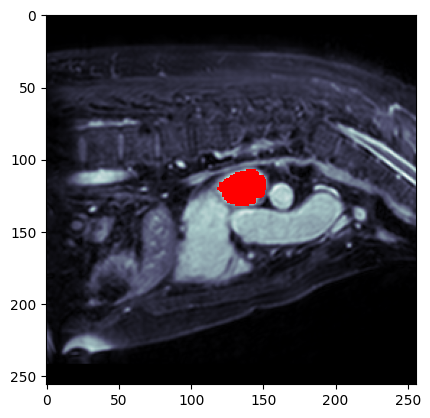

In [23]:
# Plot everything
%matplotlib inline
fig, axis = plt.subplots(1, 1)
axis.imshow(slice, cmap="bone")
mask_ = np.ma.masked_where(mask==0, mask)
axis.imshow(mask_, cmap="autumn")


In [20]:
print(slice.min(), slice.max())

0.0 0.8844492440604751


## DataSet Creation
We need to implement the following functionality:
1. Create a list of all 2D slices. To do so we need to extract all slices from all subjects
2. Extract the corresponding label path for each slice path
3. Load slice and label
4. Data Augmentation. Make sure that slice and mask are augmented identically. imgaug handles this for us, thus we will not use torchvision.transforms for that
5. Return slice and mask

In [24]:
from pathlib import Path

import torch
import numpy as np
import imgaug
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [25]:
class CardiacDataset(torch.utils.data.Dataset):
    def __init__(self, root, augment_params):
        self.all_files = self.extract_files(root)
        self.augment_params = augment_params

    @staticmethod
    def extract_files(root):
        """
        Extract the paths to all slices given the root path (ends with train or val)
        """
        files = []
        for subject in root.glob("*"):   # Iterate over the subjects
            slice_path = subject/"data"  # Get the slices for current subject
            for slice in slice_path.glob("*.npy"):
                files.append(slice)
        # print(files)
        return files


    @staticmethod
    def change_img_to_label_path(path):
        """
        Replace data with mask to get the masks
        """
        parts = list(path.parts)
        parts[parts.index("data")] = "masks"
        return Path(*parts)

    def augment(self, slice, mask):
        """
        Augments slice and segmentation mask in the exact same way
        Note the manual seed initialization
        """
        ###################IMPORTANT###################
        # Fix for https://discuss.pytorch.org/t/dataloader-workers-generate-the-same-random-augmentations/28830/2
        random_seed = torch.randint(0, 1000000, (1,)).item()
        imgaug.seed(random_seed)
        #####################################################
        mask = SegmentationMapsOnImage(mask, mask.shape)
        slice_aug, mask_aug = self.augment_params(image=slice, segmentation_maps=mask)
        mask_aug = mask_aug.get_arr()
        return slice_aug, mask_aug

    def __len__(self):
        """
        Return the length of the dataset (length of all files)
        """
        return len(self.all_files)


    def __getitem__(self, idx):
        """
        Given an index return the (augmented) slice and corresponding mask
        Add another dimension for pytorch
        """
        file_path = self.all_files[idx]
        mask_path = self.change_img_to_label_path(file_path)
        slice = np.load(file_path).astype(np.float32)  # Convert to float for torch
        mask = np.load(mask_path)

        if self.augment_params:
            slice, mask = self.augment(slice, mask)

        # Note that pytorch expects the input of shape BxCxHxW, where B corresponds to the batch size, C to the channels, H to the height and W to Width.
        # As our data is of shape (HxW) we need to manually add the C axis by using expand_dims.
        # The batch dimension is later added by the dataloader

        return np.expand_dims(slice, 0), np.expand_dims(mask, 0)


In [26]:
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa

In [27]:
seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15), # Zoom in or out
               rotate=(-45, 45)),  # Rotate up to 45 degrees
    iaa.ElasticTransformation()  # Random Elastic Deformations
                ])

In [28]:
# Create the dataset object
path = Path("Preprocessed/train/")
dataset = CardiacDataset(path, seq)

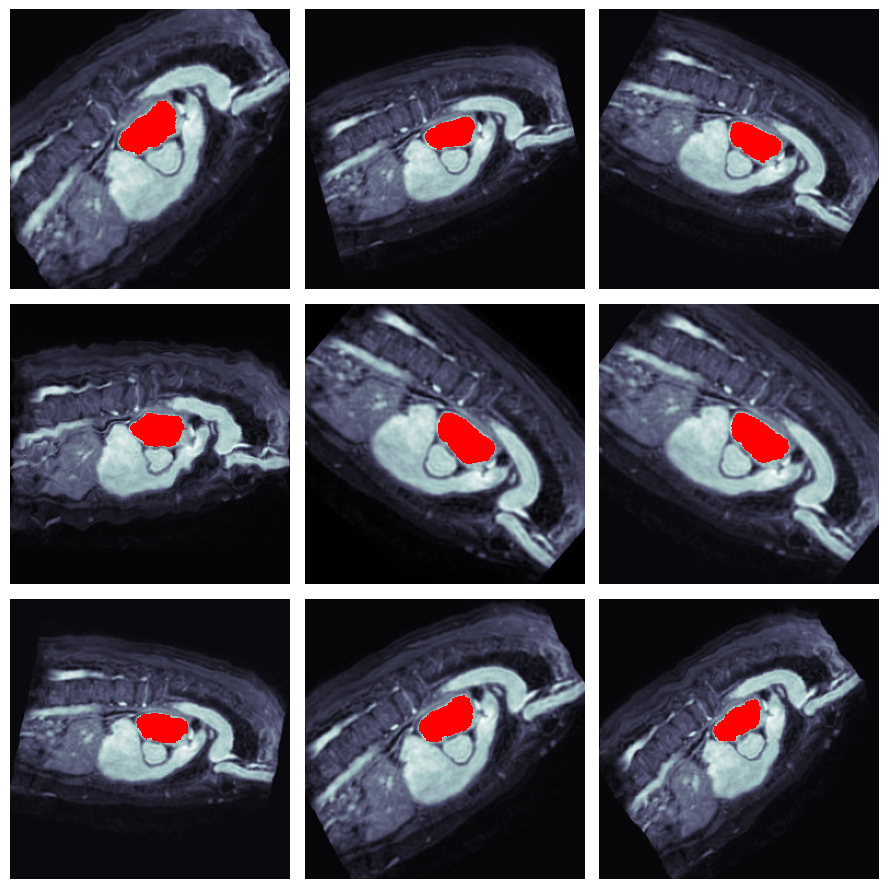

In [30]:
# Visualize our dataset
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        slice, mask = dataset[10]
        # print(mask)
        mask_ = np.ma.masked_where(mask==0, mask)
        axis[i][j].imshow(slice[0], cmap="bone")
        axis[i][j].imshow(mask_[0], cmap="autumn")
        axis[i][j].axis("off")

plt.tight_layout()


## Model Creation
We will use the most famous architecture for this task, the U-NET (https://arxiv.org/abs/1505.04597).

In [31]:
class DoubleConv(torch.nn.Module):
    """
    Helper Class which implements the intermediate Convolutions
    """
    def __init__(self, in_channels, out_channels):

        super().__init__()
        self.step = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, 3, padding=1),
                                        torch.nn.ReLU(),
                                        torch.nn.Conv2d(out_channels, out_channels, 3, padding=1),
                                        torch.nn.ReLU())

    def forward(self, X):
        return self.step(X)

In [32]:
class UNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = DoubleConv(1, 64)
        self.layer2 = DoubleConv(64, 128)
        self.layer3 = DoubleConv(128, 256)
        self.layer4 = DoubleConv(256, 512)

        self.layer5 = DoubleConv(512+256, 256)
        self.layer6 = DoubleConv(256+128, 128)
        self.layer7 = DoubleConv(128+64, 64)
        self.layer8 = torch.nn.Conv2d(64, 1, 1)

        self.maxpool = torch.nn.MaxPool2d(2)

    def forward(self, x):

        x1 = self.layer1(x)
        x1m = self.maxpool(x1)

        x2 = self.layer2(x1m)
        x2m = self.maxpool(x2)

        x3 = self.layer3(x2m)
        x3m = self.maxpool(x3)

        x4 = self.layer4(x3m)

        x5 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x4)
        x5 = torch.cat([x5, x3], dim=1)
        x5 = self.layer5(x5)

        x6 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x5)
        x6 = torch.cat([x6, x2], dim=1)
        x6 = self.layer6(x6)

        x7 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x6)
        x7 = torch.cat([x7, x1], dim=1)
        x7 = self.layer7(x7)

        ret = self.layer8(x7)
        return ret

## Train

In [ ]:
!pip install pytorch_lightning

In [34]:
from pathlib import Path

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import imgaug.augmenters as iaa
import numpy as np
import matplotlib.pyplot as plt

In [35]:
seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15),
              rotate=(-45, 45)),
    iaa.ElasticTransformation()
])

In [37]:
# Create the dataset objects
train_path = Path("Preprocessed/train/")
val_path = Path("Preprocessed/val")

train_dataset = CardiacDataset(train_path, seq)
val_dataset = CardiacDataset(val_path, None)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 1919 train images and 352 val images


In [38]:
batch_size = 8
num_workers = 2

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)


In [39]:
class DiceLoss(torch.nn.Module):
    """
    class to compute the Dice Loss
    """
    def __init__(self):
        super().__init__()

    def forward(self, pred, mask):

        # Flatten label and prediction tensors
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)
        counter = (pred * mask).sum()  # Numerator
        denum = pred.sum() + mask.sum() + 1e-8  # Denominator. Add a small number to prevent NANS
        dice =  (2*counter)/denum
        return 1 - dice


In [40]:
class AtriumSegmentation(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.model = UNet()

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = DiceLoss()

    def forward(self, data):
        return torch.sigmoid(self.model(data))

    def training_step(self, batch, batch_idx):
        mri, mask = batch
        mask = mask.float()
        pred = self(mri)

        loss = self.loss_fn(pred, mask)

        self.log("Train Dice", loss)

        if batch_idx % 50 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), "Train")

        return loss

    def validation_step(self, batch, batch_idx):
        mri, mask = batch
        mask = mask.float()
        pred = self(mri)

        loss = self.loss_fn(pred, mask)

        self.log("Val Dice", loss)

        if batch_idx % 2 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), "Val")

        return loss

    def log_images(self, mri, pred, mask, name):

        pred = pred > 0.5

        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(mri[0][0], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][0] == 0, mask[0][0])
        axis[0].imshow(mask_, alpha=0.6)

        axis[1].imshow(mri[0][0], cmap="bone")
        mask_ = np.ma.masked_where(pred[0][0] == 0, pred[0][0])
        axis[1].imshow(mask_, alpha=0.6)

        self.logger.experiment.add_figure(name, fig, self.global_step)

    def configure_optimizers(self):
        return [self.optimizer]

In [41]:
# Instanciate the model and set the random seed
torch.manual_seed(0)
model = AtriumSegmentation()

In [42]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Dice',
    save_top_k=30,
    mode='min')

In [43]:
# Create the trainer
# Change the gpus parameter to the number of available gpus in your computer. Use 0 for CPU training

trainer = pl.Trainer(accelerator="auto",
                     logger=TensorBoardLogger(save_dir="/content/drive/MyDrive/output"),
                     log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=30)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_loader, val_loader)

## Evaluation

In [44]:
import nibabel as nib
from tqdm.notebook import tqdm
from celluloid import Camera

In [45]:
# load a checkpoint
model = AtriumSegmentation.load_from_checkpoint("/content/drive/MyDrive/output/lightning_logs/version_0/checkpoints/epoch=29-step=7200.ckpt")

In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval();
model.to(device);

In [47]:
# Evalute the complete validation dataset
preds = []
labels = []

for slice, label in tqdm(val_dataset):
    slice = torch.tensor(slice).to(device).unsqueeze(0)
    with torch.no_grad():
        pred = model(slice)
    preds.append(pred.cpu().numpy())
    labels.append(label)

preds = np.array(preds)
labels = np.array(labels)

  0%|          | 0/352 [00:00<?, ?it/s]

In [48]:
# Compute overall Dice Score (1- DiceLoss)
model.loss_fn(torch.from_numpy(preds), torch.from_numpy(labels))  # two possibilities

tensor(0.1044)

In [49]:
dice_score = 1-DiceLoss()(torch.from_numpy(preds), torch.from_numpy(labels).unsqueeze(0).float())
print(f"The Val Dice Score is: {dice_score}")

The Val Dice Score is: 0.8955789804458618


## Visualization

In [51]:
# load a test subject from the dataset and estimate the position of the left atrium
subject = Path("/content/Data/Task02_Heart/imagesTs/la_002.nii.gz")
subject_mri = nib.load(subject).get_fdata()

In [52]:
# We preprocess the scan and crop 32 px from top, bottom, back and front
subject_mri = subject_mri[32:-32, 32:-32]
standardized_scan = standardize(normalize(subject_mri))

In [53]:
standardized_scan.shape

(256, 256, 140)

In [54]:
preds = []
for i in range(standardized_scan.shape[-1]):
    slice = standardized_scan[:,:,i]
    with torch.no_grad():
        pred = model(torch.tensor(slice).unsqueeze(0).unsqueeze(0).float().to(device))[0][0]
        pred = pred > 0.5
    preds.append(pred.cpu())

In [ ]:
fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid

for i in range(standardized_scan.shape[-1]):
    plt.imshow(standardized_scan[:,:,i], cmap="bone")
    mask = np.ma.masked_where(preds[i]==0, preds[i])
    plt.imshow(mask, alpha=0.5, cmap="autumn")

    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation

In [56]:
from IPython.display import HTML
HTML(animation.to_html5_video())  # convert the animation to a video